# Fast-Neutron Lab
## Data analysis code and lab notebook

### Introduction
* This 'Jupyter Notebook' is your manual, data analysis and log book all at the same time. It consists of individual cells of text or Python code and you can edit or add cells to your heart's content.
* When using the notebook, there are two modes: *command* and *edit* mode. In command mode, you can add, move, run or delete cells. In edit mode, you modify its content. Use the *Esc* key or click outside the cell to leave edit mode. With *shift* + *return* you can run it directly from edit mode.
* When you 'run' a cell it will either be formated or executed depending on whether it is a text cell or a code cell, respectivly. The output will be shown inside the notebook.
* It is best to run the notebook piece-by-piece as we are progressing through the lab. If something doesn't work as expected, try 'Kernel->Restart' to get a fresh working environment.
* Code cells support typical editing features of an IDE, such as tab-complete. You find more info in the 'Help' menu including all keyboard shortcuts!
* **Please note**: The code is not supposed to work out-of-the-box but needs some tweaks from your side to complete all the way through! So if you encounter an error, don't despair, try to fix it and ask for help should you get stuck!

## How to transfer data for the analysis
The data is stored in .root files to be used with the *ROOT* data analysis framework. 
To analyse the data here instead, we need to extract the histogrammed data from the file into a format we can easliy import.

For this, use the command *ROOTtoCSV*. 
The prgrams expect two input parameters the name of the *ROOT* file and the name of the histogram you want to extract.

Then copy the data into the folder where you run this Jupyter Notebook from -- or use the upload function in the main Jupyter screen.

## How to run this analysis
Some initialization in your program:
To plot things, you use the matplotlib library. You need to import the library before the first use and initialize the interactive plots inside the notebook:


In [1]:
import numpy as np
import scipy
# enable interactive notebook plots:
# (alternative: use 'inline' instead of 'notebook' for static images)
%matplotlib notebook
import matplotlib.pyplot as plt

# Plotting the time-of-flight data

* The aim is to transform the TDC spectrum into a TOF spectrum.
* First you need to import the data and create a histogram.
* There is already a class ready to be used called histhelpers.

Loaded file 'hvt_2_run2208.csv' imported from ' Data2208.root'


<IPython.core.display.Javascript object>


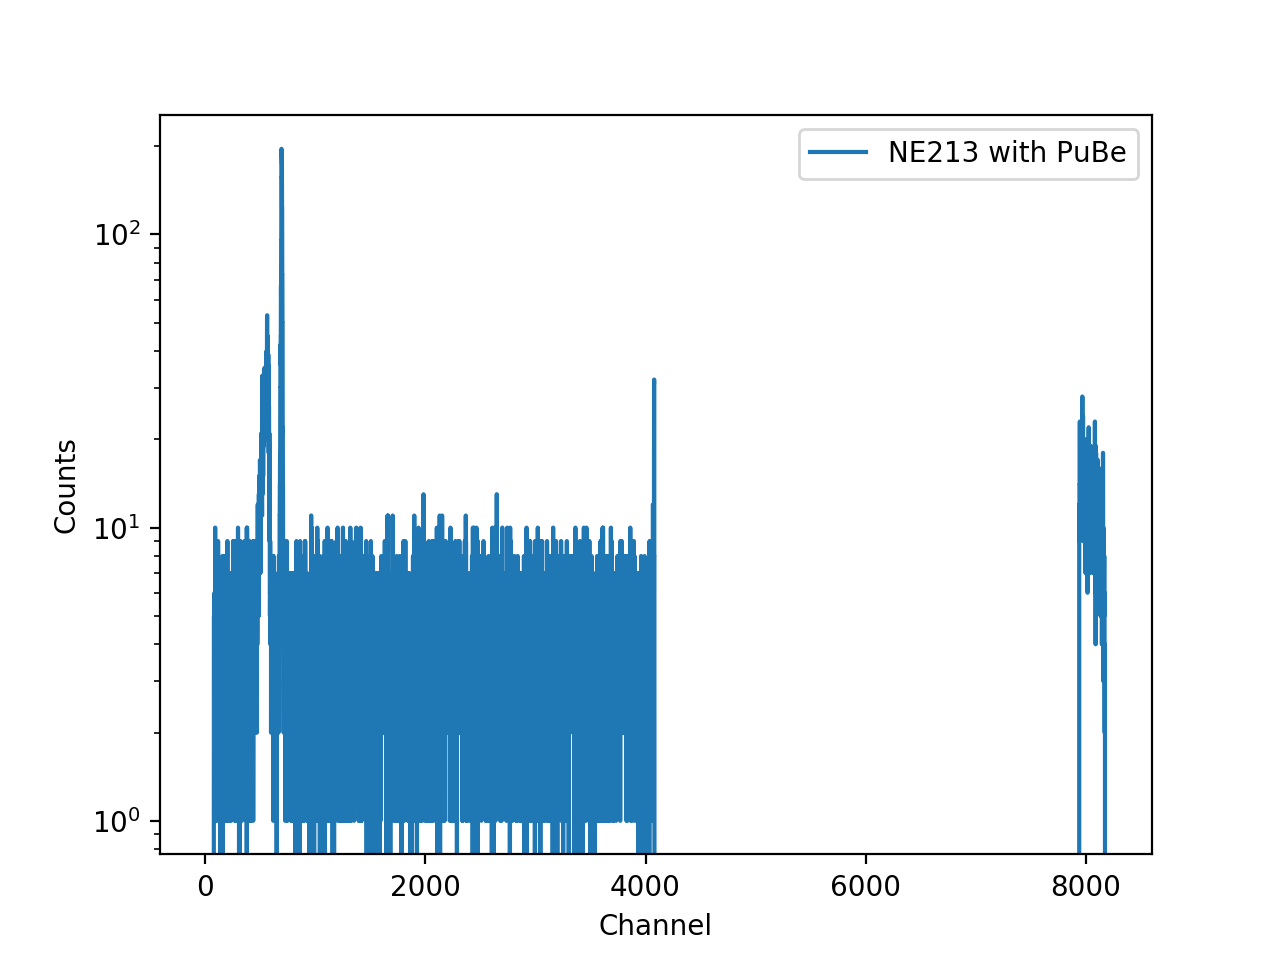

In [2]:
import histhelpers
from histhelpers import getBinCenters
# enter the data from TDC YAP 0
tof = histhelpers.import_hist_from_csv('hvt_2_run2208.csv') # TODO: put correct file name!
print("Loaded file '{}' imported from '{}'".format(tof.filename, tof.name))


fig, axes = plt.subplots() # makes new plot
plt.yscale('log')
axes.plot(getBinCenters(tof.bins), tof.data, label="NE213 with PuBe", drawstyle="steps")
plt.xlabel('Channel')
plt.ylabel('Counts')

plt.legend()
plt.show()

# Converting the TDC spectrum a to time-of-flight spectrum

* To determine the $T_0$ reference point you need to find the gamma-flash.
* The precise peak position of the gamma flash can be found by fitting a Gaussian to the data.
* First plot the data:

<IPython.core.display.Javascript object>


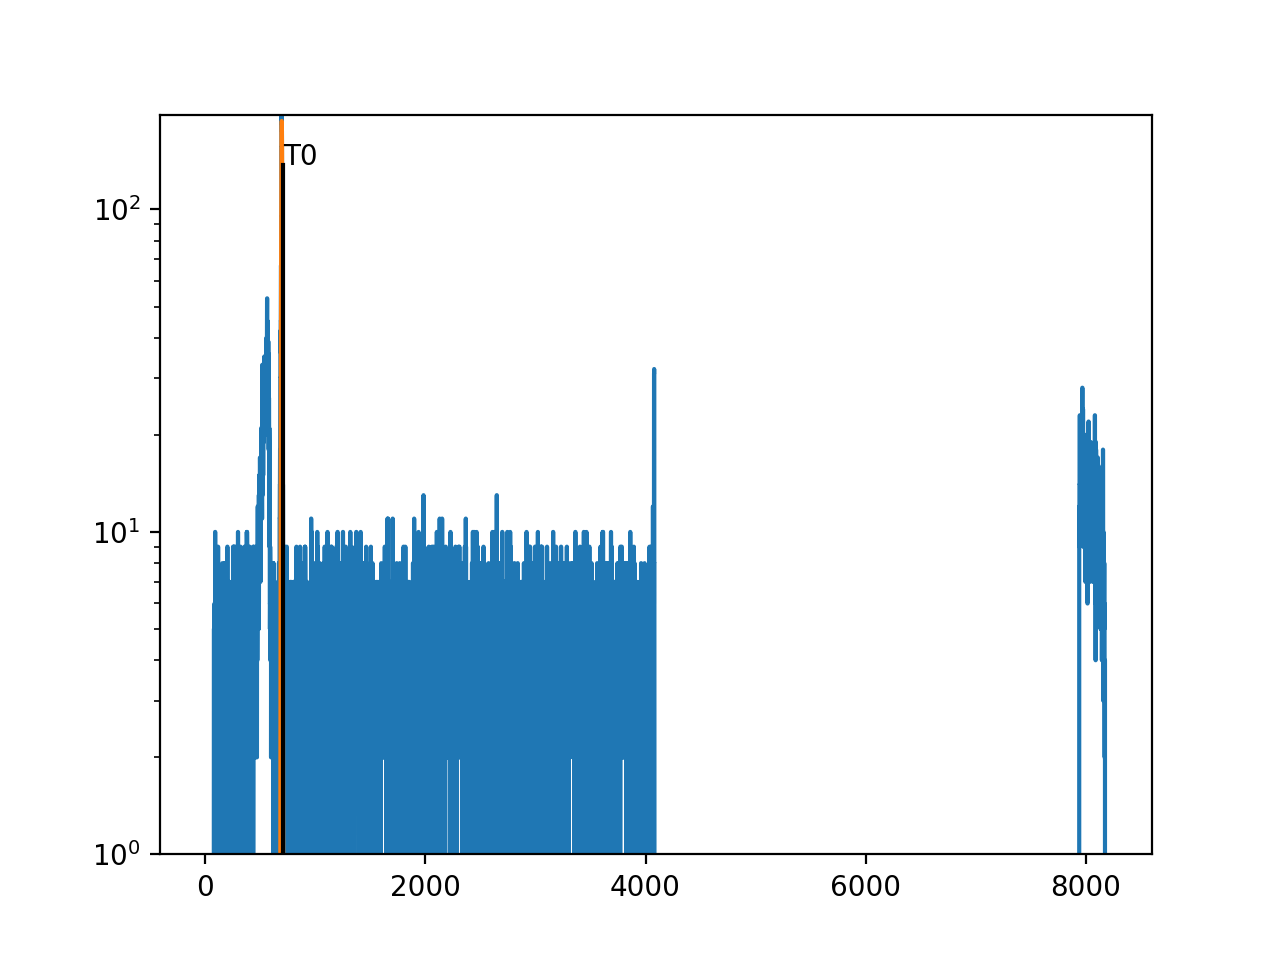

In [3]:
fig, axes = plt.subplots()

# plot data
plt.yscale('log') # comment out for lin scale
plt.ylim(ymin=1, ymax=max(tof.data))
axes.plot(getBinCenters(tof.bins), tof.data, label="TOF data", ds="steps") # ls == linestyle

Now adjust the arguments of the routine *fit_gaussians_at_pos* from the *fithelpers.py* file to match the gamma flash position:

In [4]:
import fithelpers
# TODO: adjust position to be fitted in function's argument below
gammaflash_fit = fithelpers.fit_gaussian_at_pos(getBinCenters(tof.bins), tof.data, pos=700)
print(f"gammaflash_fit1: {gammaflash_fit.mu}")
axes.plot(getBinCenters(tof.bins), gammaflash_fit.value(getBinCenters(tof.bins)), label="Gauss Fit")

gammaflash_fit1: 695.9081022078676


# Calibration

<IPython.core.display.Javascript object>


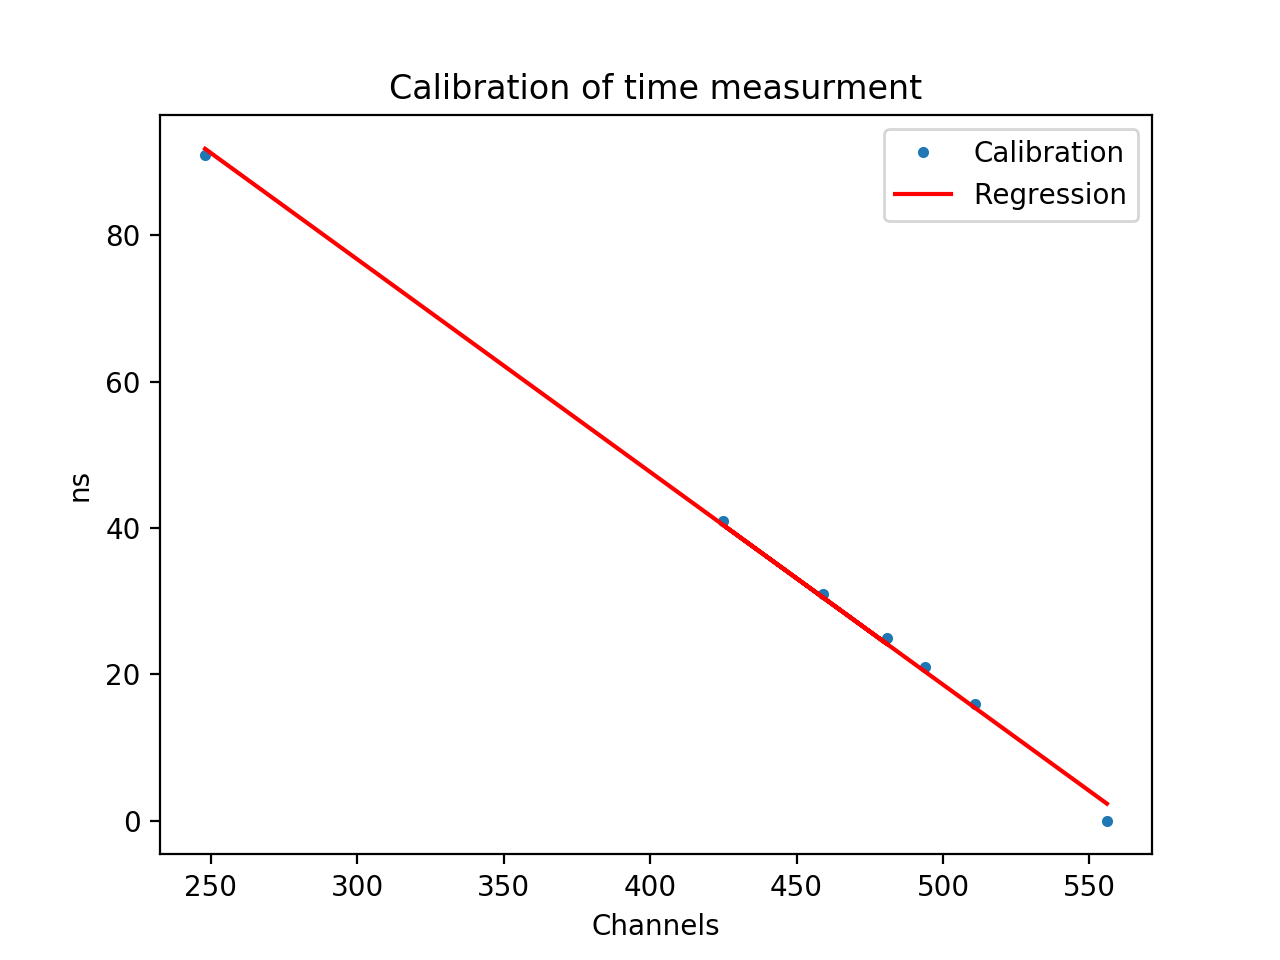

LinregressResult(slope=-0.2905521336379322, intercept=163.8874960238281, rvalue=-0.9991755122738467, pvalue=3.7473346318065344e-08, stderr=0.005279768056879249)


In [12]:
ListOfPeaks = np.array([556, 511, 494, 459, 425, 481, 248]) #Values of peaks in units of Channels
ListOfTime = np.array([0, 16, 21, 31, 41, 25, 91]) #List of values in units of nano-seconds
fig = plt.subplots()
plt.plot(ListOfPeaks, ListOfTime, '.', label = 'Calibration')


from scipy.stats import linregress
Regression = linregress(ListOfPeaks, ListOfTime)
print(Regression)
plt.plot(ListOfPeaks, Regression[0] * ListOfPeaks + Regression[1], 'r', label = 'Regression')
plt.ylabel(r'ns')
plt.xlabel('Channels') 
plt.title('Calibration of time measurment')

plt.legend()
plt.show()

slope = - Regression[0] #We do this because the sign of the slope has no physical meaning.


## Optional Challenge: perform the fit on your own!
In the previous cell we "cheated" a bit using ready-made helper code; why not set the parameters yourself and run [curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) yourself? You'll find the necessary inspiration in the *Introduction for FYSC12 Labs* Jupyter Notebook you've received.

*Discuss/state below*: What are the uncertainties of the fitted parameters? Is this better than what you would expect reading the values off by eye?

In [6]:
from scipy.optimize import curve_fit #importing fitting library
import math
x_val = tof.bins #TOF values
y_val = tof.data #number of counts

#....... YOUR CODE HERE ....... #Not tested but should work.

def FitToGaussian(xlist, ylist, position):
    #Stating some definitions
    index = 0
    def Gaussian(x, *args):
        A = args[0]
        mu = args[1]
        try:
            sigma = args[2]
        except:
            sigma = 1
        return A * math.exp(-(x-mu)**2/(2 * sigma**2))
        
    try:
        for i in range(len(xlist)):
            if position == xlist[i]:
                p = np.array([xlist[i], [ylist[i]]])
                index = i
    except Exception as E:
        raise E
    try:
        upperboundary = min(len(xlist) - index, 100)
        lowerboundary = min(index, 100)
        #This is how curve_fit works
        GaussianFit = curve_fit(Gaussian, xlist[index - lowerboundary : index + upperboundary], ylist[index - lowerboundary : index + upperboundary], p0 = p)
        return GaussianFit
    except Exception as E:
        raise E
    
#FitToGaussian(x_val, y_val, 700)


## Calcuating $T_0$

Now put the correct values in to calcuate the reference time $T_0$:

**Optional**: Document how you determine `seconds_per_TDC_channel` by e.g. creating a new cell where you load the TDC calibration data.

In [7]:
#Enter the distance from detector to neutron source:
distance =  1.141 # in [m]; TODO: measure and put right value here!
speed_of_light = 2.99792458e8 # in [m/s]
gammaflash_position = gammaflash_fit.mu # replace with value read off by eye in case you skipped the fit
seconds_per_TDC_channel = slope * 10**(-9) # in s/ch; TODO: measure and put right value here!


T0 = gammaflash_position + (distance / speed_of_light)/(slope * 10**(-9)) # TODO: add a calculation here!
print(gammaflash_position * slope)
print ("T0 calculated to be at: {} [ch]".format(T0))

# DRAW A LINE AT T0:
axes.text(T0, max(tof.data)*.7, "T0")
axes.plot((T0, T0), (1, max(tof.data)*.7), 'k-')

202.19758391242013
T0 calculated to be at: 709.0071845603437 [ch]


For clarity, let's put the axis into the correct time binning, invert it and shift the zero position to T0

<IPython.core.display.Javascript object>


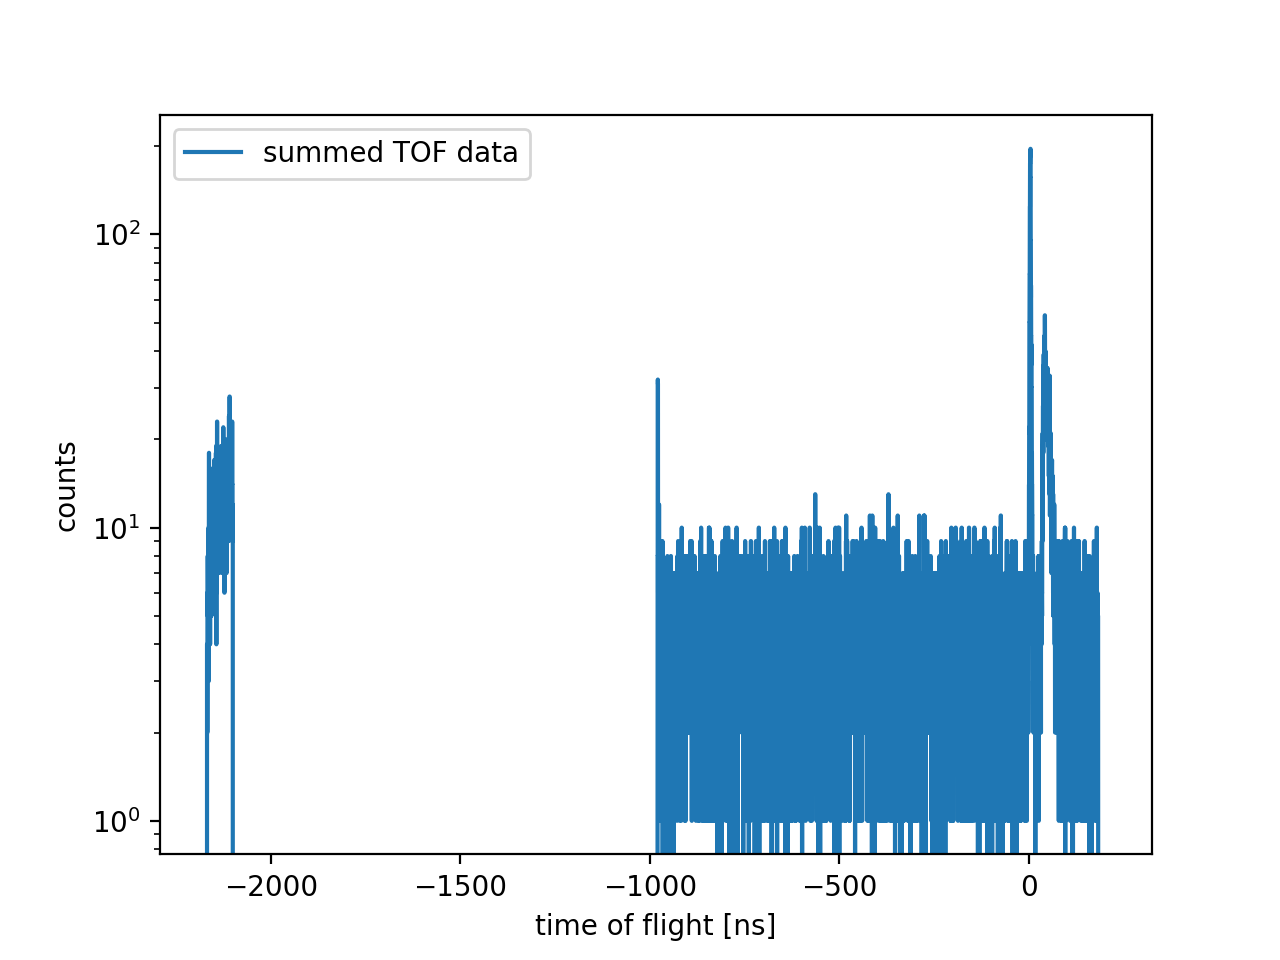

In [8]:
# copy spectrum into new data structure (before messing with it)
import copy
tof_in_ns = copy.deepcopy(tof)

# now align the axis so that 0 =^= T0 and convert TDC channel to time [ns]
tof_in_ns.bins = ((-1) * tof.bins + T0) * seconds_per_TDC_channel
tof_in_ns.bins *= 1e9 # convert s to ns

# plot the result
fig, axes = plt.subplots()
axes.plot(getBinCenters(tof_in_ns.bins), tof_in_ns.data, label="summed TOF data", ds="steps")
plt.xlabel('time of flight [ns]')
plt.ylabel('counts')
plt.yscale('log')
plt.legend()

# Clean-up of the spectra and background subtraction
Let's remove "unphysical" part with $t<0$ of the ToF spectrum

<IPython.core.display.Javascript object>


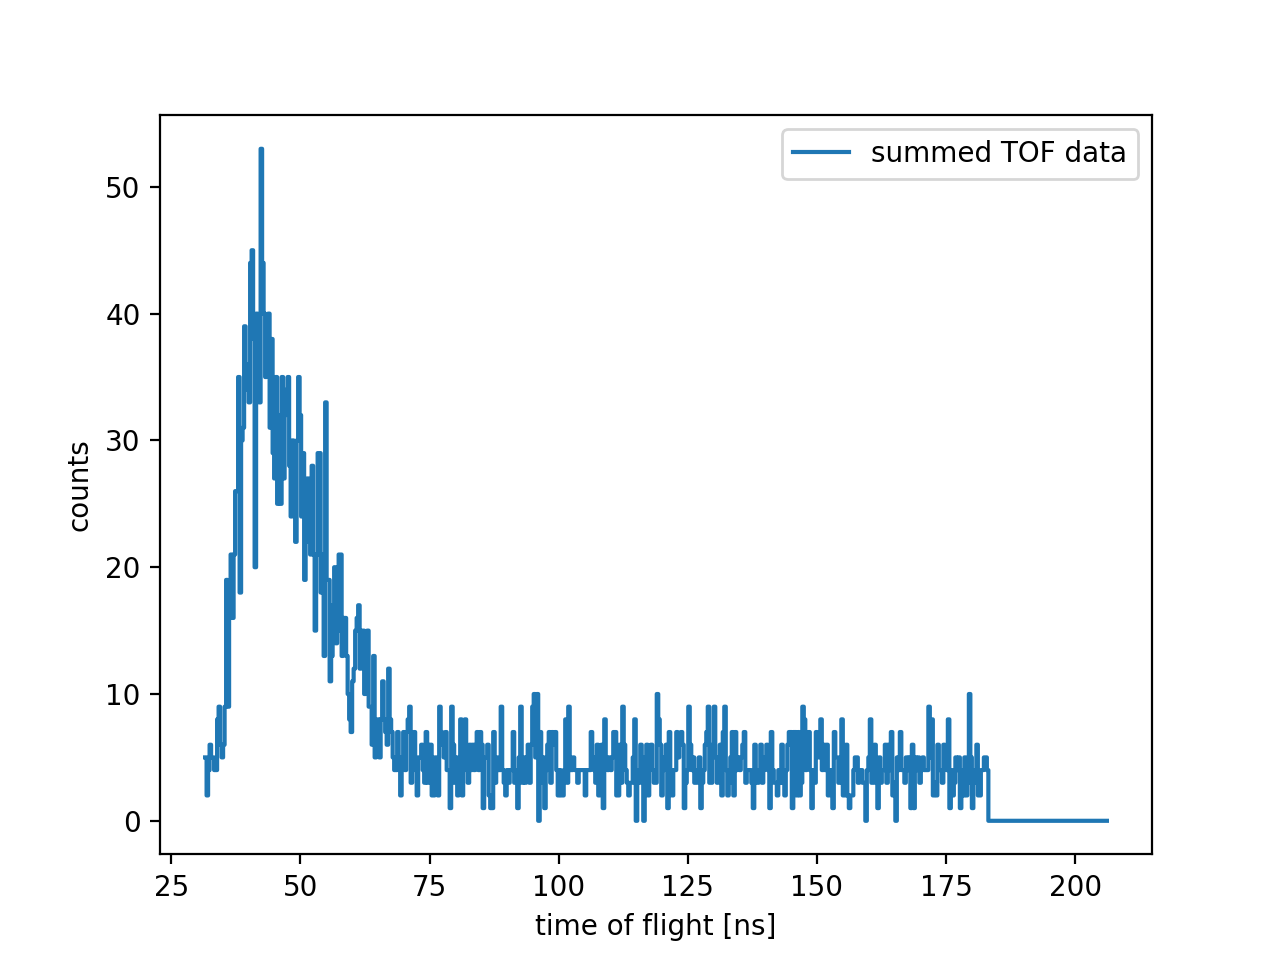

In [9]:
# make copy of spectrum first
tof_stripped = copy.deepcopy(tof_in_ns)

## remove some of the data that would mess up our calculation:
## - find all bins with x > 0, remember last index (just for the very curious -- why last index and not first: the order in memory stays but we flipped the axis when we multiplied with -1 above)
idx_low = np.where(tof_stripped.bins>31)[0][-1]
#idx_high = np.where(Tn.bins>100)[0][-1] # could be used to remove upper part (replaces '0' below)

## strip all other bins to remove those with x < 0
tof_stripped.bins = tof_stripped.bins[0:idx_low]
tof_stripped.data = tof_stripped.data[0:idx_low-1] # mind the offset, len(bins) = len(data)+1 !
# plot the result
fig, axes = plt.subplots()
axes.plot(getBinCenters(tof_stripped.bins), tof_stripped.data, label="summed TOF data", ds="steps")
plt.xlabel('time of flight [ns]')
plt.ylabel('counts')
#plt.yscale('log')
plt.legend()

## Optional Task: Subtract the random background from the spectrum (you still need to run the cell, even if you don't touch this part otherwise)

Think about (and answer below): How can you best determine the amount of background? What are the implications of removing it? Is this a correction or a purely cosmetic step?

<IPython.core.display.Javascript object>


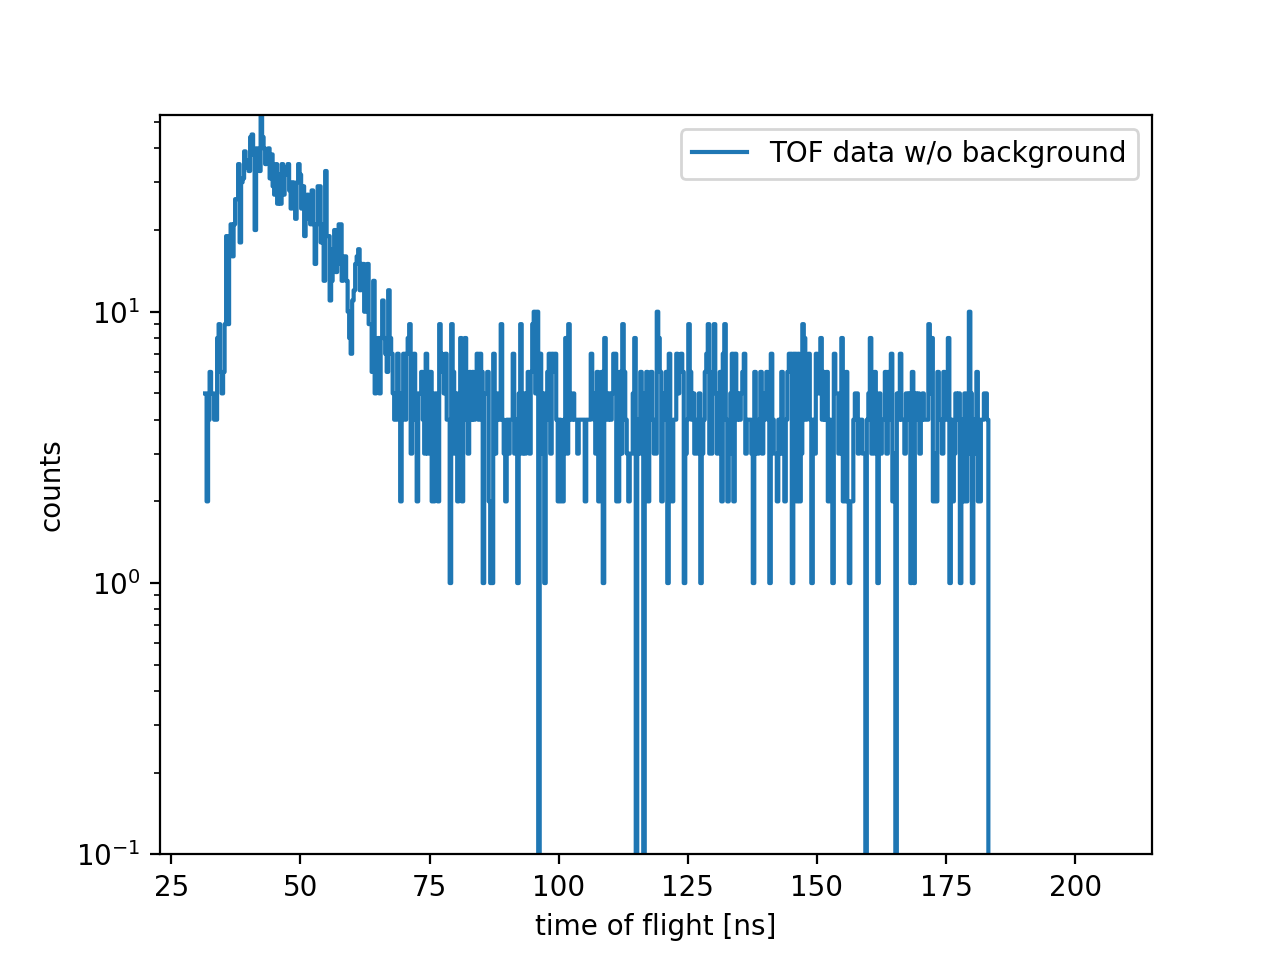

In [10]:
tof_wo_bckgrd = copy.deepcopy(tof_stripped)
# subtract background of random triggers
#We use a linear regression of values that are irrelevant.
Linefunc = lambda k,x,m : k * x + m # Just a linear function
#We now choose the irrelevant data.
#This was not completed in the sense of not being able to effectivly choosing data.

tof_wo_bckgrd.data -= 0 # TODO: determine (fit?) random background and put here

# values < 0 are unphysical -- set to zero instead
# tof_wo_bckgrd.data[tof_wo_bckgrd.data < 0] = 0

# plot the result
fig, axes = plt.subplots()
plt.ylim(0.1,max(tof_wo_bckgrd.data))
axes.plot(getBinCenters(tof_wo_bckgrd.bins), tof_wo_bckgrd.data, ds="steps", label="TOF data w/o background")
plt.xlabel('time of flight [ns]')
plt.ylabel('counts')
plt.yscale('log')
plt.legend()

# Convert the time-of-flight to an energy spectrum

<IPython.core.display.Javascript object>


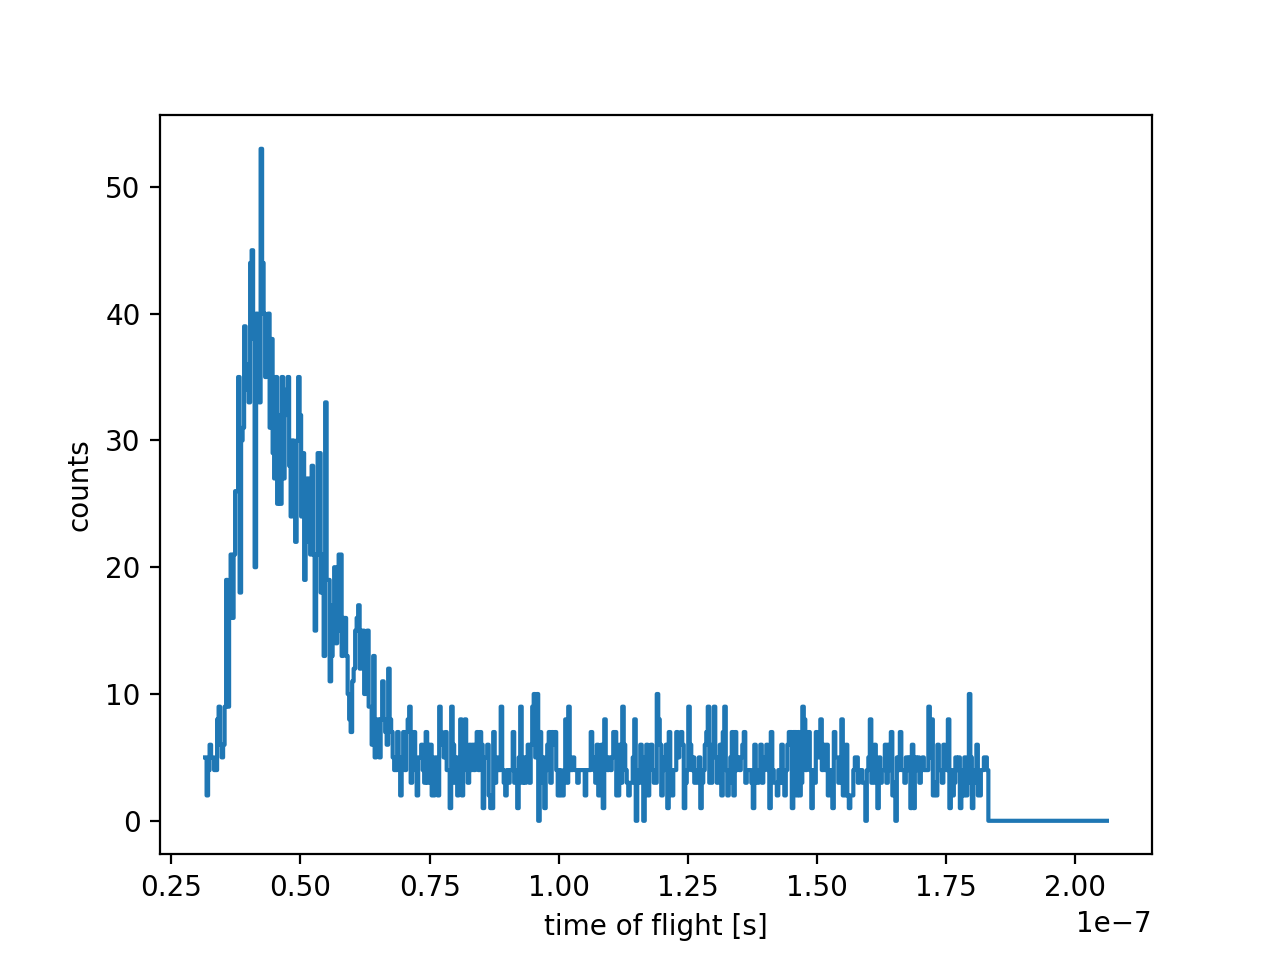

<IPython.core.display.Javascript object>


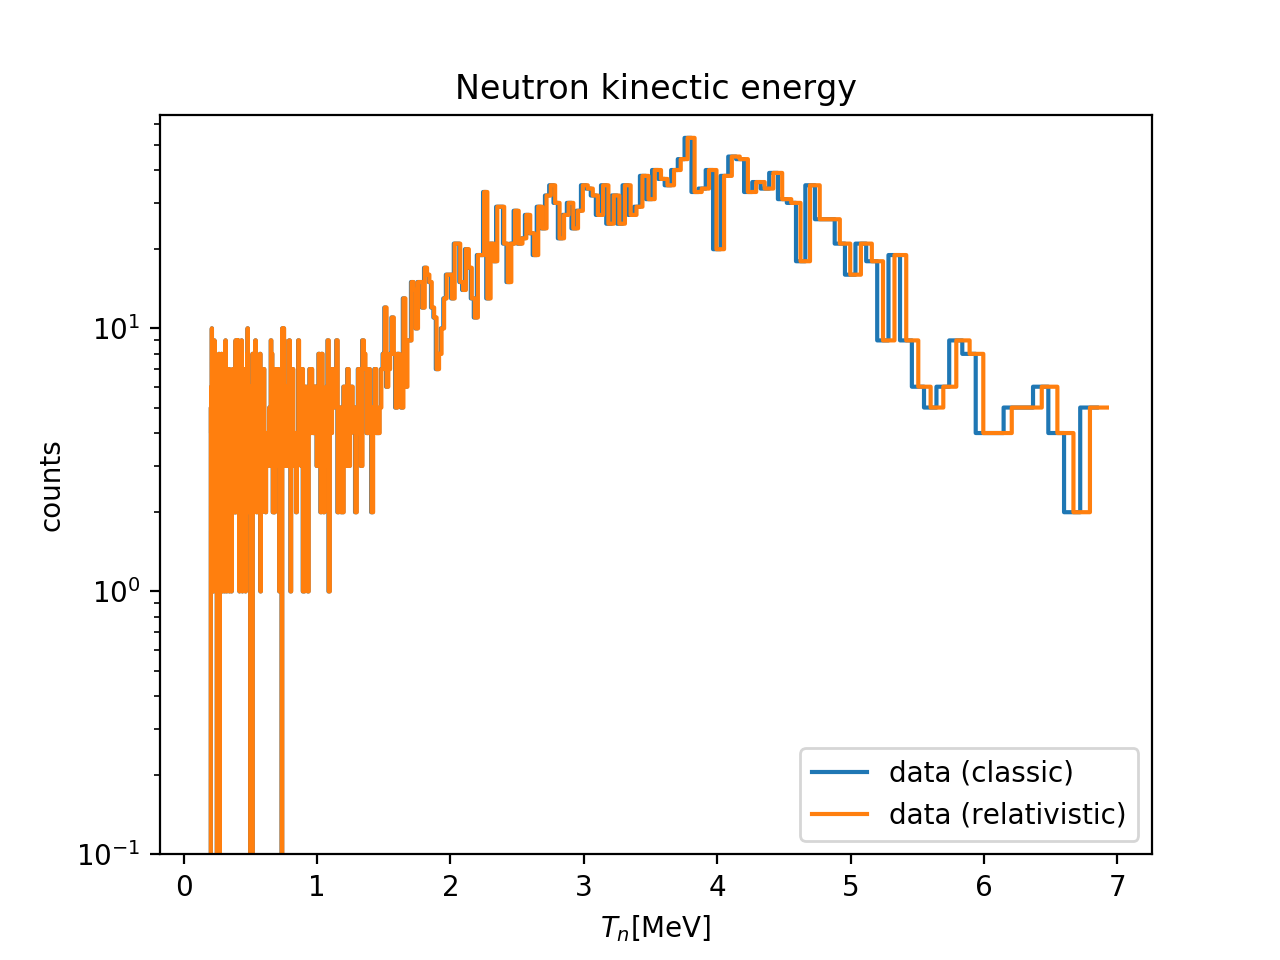

In [11]:
## constants:
#Add neutron mass
M_n = 939.5654133  ## mass of n in MeV/c**2; TODO: put right value here!

Tn = copy.deepcopy(tof_wo_bckgrd)
Tn.bins *= 1e-9 # convert to seconds

# show the raw data once more for clarity
fig, axes = plt.subplots()
axes.plot(getBinCenters(Tn.bins), Tn.data, label="data (cut)", drawstyle="steps")
plt.xlabel('time of flight [s]')
plt.ylabel('counts')

## non-relativistic/classic approach:
Tn_cls = copy.deepcopy(Tn)
Tn_cls.bins = 0.5 * (M_n / pow (speed_of_light, 2)) * ( pow(distance, 2) / pow(Tn_cls.bins, 2) )
## relativistic approach: B. Nilsson PhD thesis, LU, 2003, equation 2.7
Tn_rlv = copy.deepcopy(Tn)
beta = 1. / ( 1. + ((Tn_rlv.bins - distance / speed_of_light) * speed_of_light / distance))
Tn_rlv.bins = M_n * ( ( 1. / np.sqrt(1. - pow(beta, 2))) - 1. )

# plot the result
fig, axes = plt.subplots()
axes.plot(getBinCenters(Tn_cls.bins), Tn_cls.data, label="data (classic)", drawstyle="steps")
axes.plot(getBinCenters(Tn_rlv.bins), Tn_rlv.data, label="data (relativistic)", drawstyle="steps")

plt.xlabel(r'$T_n \mathrm{[MeV]}$')
plt.ylabel('counts')
plt.yscale('log')
plt.ylim(ymin=0.1)
plt.title("Neutron kinectic energy")
plt.legend()

# Discussion

Please answer the questions below, make sure that all plots above look good (i.e. show what you want to highlight and are labeled) and submit your Jupyter Notebook.

1. what parameters enter into the calculation to get the energy spectrum from the original data recorded by the TDC?
2. what are their uncertainties and how do they affect the result? How can you practically estimate this effect?
* what would you say affects the efficiency of detecting a neutron with today's setup?
* how can you convince your colleagues that you have measured neutrons today?
* what is the background in this technique and how does it affect your measurement?
* compared to charged particles, why is it so difficult to measure the neutron's energy in general?
* what is the function of the CFD ("constant fraction descriminator") module in the setup? Do we actually need it?
* can you come up with suggestions for improvment of this technique?

... and: would you be interested in learning more in an *Advanced Neutron Tagging Lab*? ;)

.... YOUR ANSWERS HERE ....
### Question 1
To retrieve the final energy-spectrum we had to include the calibration, to convert channels to seconds; The mass of the neutron in MeV and also the gaussion fit for the gamma-flash aswell as the distance from the source.

### Question 2
The major uncertainties lie in the measurments of distance and calibration. The distance itself can be interpretade in various way, to include the distance from the source to the end of the scintillator, only the distance of the source to the beginning of the scintillator or somewhere inbetween; This is due to the neturon having a probability to interact during the entire length of the scintillator, which was measured to be $19.4 \pm 0-05 cm$. To get a rought estimate of the error one do the calculations with the length of the two cases and the error would lie somewhere inbetween. Also the reaction of the source could happen anywhere in the source which would also increase the path which was traveled.

The calibration uncertainties lie in the uncertaninty of the linear fit. With more data-point one could decrease the uncertaintity. If one include the uncertainties from the calibration one also got a major difference in energy.

Length from the source is estimated to be $1.141$ m.

### Question 3
The efficiency of the experiment could be increased with a longer detector. Also if one increased the flux to the scintillator, by moving it closer to the source, one could improve the efficency however this would result in a larger relative error.
Also a change of material could increase the chance of detecting the neutron, one with higher density that is or larger nuclei radii.

### Question 4
If one was to apply a electromagnetic field before the scintillator it would not attract the neutrons due to the netural charge and also when sheilding with lead, to block photons, the neutrons still went pass. Thus one could conclude a neturally charged particle which was not a photon and the neutron being the only option.

### Question 5
The source of the background was the false measurments due to a start but not a stop, implying that the neutron activiated the TDC but no $\gamma$-ray was detected in the YAP-detector which resulted in the logical signal being turned on until the next detection of a $\gamma$-ray occured. 

### Question 6
Since the neutron is neutrally charged they do not interact with the columb interactions; This implies that the neutron only interact with a nuclei which is much smaller than the radius of an entire atom. This decreases the probability of interaction which in turns makes them harder to detect. Also fast neutrons have a smaller cross-section that for example thermal neutrons which also decreases the probability of interaction.

### Question 7
The effect of the CFD is to align the incomming signal in time to get a accurate description of the signal when comparing it to other signals. The incoming signals have some amplitude and by starting at rougly $\frac{1}{3}$ of the amplitude each of the signals is matched. This results in an walk-free timing situation.

### Question 8
As stated before, increasing the length of the detector would increase the probability of interaction within the scintillator, but also increasing the distance from the source to the beggining of the detector would decrease the uncertainty. Measuring over a longer period would result in more data, and with more data one could make more accurate statistical assumptions and regressions meaning less uncertainty. If the distance is increased, the flux would decrease which implies less measurments, one would compensate with longer data-recording, such as over a weekend or over a whole week. Using analog equipment one can compute with ease but with digital-equipment, the single-rack card, one could implement more functions, such as graphing each individual signal or comparing each incoming signal with eachother.
One could also look at the time-resultion of the TDC, if the the time-resultion was higher one would get better results.
